# Auxtel Spectra analysis : prediction transmission with gain and PTC

- Author : Sylvie Dagoret-Campagne
- creation date : 2023-12-12
- last update : 2023-12-12
- - last update : 2024-01-10
- affiliation : IJCLab/IN2P3/CNRS

After a notebook from Jeremy Neveu


- 1) Run a first time to generate the fitted parameter file
  2) Run a second time to apply the fitted parameters

## Imports

In [93]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [94]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys

In [95]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [96]:
machine_name = os.uname().nodename
print(machine_name)
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    #machine_name_notebook platform = 'dagoret-nb'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)   
elif "dagoret-nb" in machine_name:
    print("Set environement for Rubin Platform at  USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

dagoret-nb
Set environement for Rubin Platform at  USDF


In [97]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [98]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

#README.md        darksky.dat      filter_r.dat     hardware_g.dat   hardware_y.dat   lens3.dat        total_g.dat      total_y.dat
#README_SOURCE.md detector.dat     filter_u.dat     hardware_i.dat   hardware_z.dat   m1.dat           total_i.dat      total_z.dat
#atmos_10.dat     filter_g.dat     filter_y.dat     hardware_r.dat   lens1.dat        m2.dat           total_r.dat      version_info
#atmos_std.dat    filter_i.dat     filter_z.dat     hardware_u.dat   lens2.dat        m3.dat           total_u.dat
hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [99]:
#FILTERWL: precalculated array containing center, boundaries and width of each filter.
#index 0 : minimum wavelength of filter border
#index 1 : minimum wavelength of filter border
#index 2 : center wavelength of filter
#index 3 : filter width


FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

FILTERWL_auxtel = np.array([[ 352.7 ,  395.9 ,  374.3 ,   43.2 ],
                     [ 387.6 ,  566.2 ,  476.9 ,  178.6 ],
                     [ 541.4 ,  715.5 ,  628.45,  174.1 ],
                     [ 673.3 ,  870.9 ,  772.1 ,  197.6 ],
                     [ 805.6 , 1090.7 ,  948.15,  285.1 ]])


F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
Jy_to_ergcmm2sm1hzm1 = 1e-23
DT = 30.0 # seconds
gel = 1.1
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
A  = np.pi*642.3**2 # cm2  Reff=6.423 m
A_auxtel  = 9636.0 # cm2

#ZPT_cont =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)
ZPTconst = 2.5*np.log10(F0*Jy_to_ergcmm2sm1hzm1*A*DT/gel/hP)

In [100]:
def fII0(wl,s):
    """
    Parameters:
    S : is the atmospheric transmission times the instrumental transmission
    wl :is the wavelength transmission

    return:
    II0 integral which is unitless
    """

    # clean
    indexes_sel = np.where(s>0.002)[0]
    wlmin = wl[indexes_sel].min()
    wlmax = wl[indexes_sel].max()

    indexes_sel = np.where(np.logical_and(wl>wlmin,wl<wlmax))[0]
    
    return np.trapz(s[indexes_sel]/wl[indexes_sel],wl[indexes_sel])
      
def fII1(wl,phi,wlb):
    """
    """
    return np.trapz(phi*(wl-wlb),wl)
  
def ZPT(wl,s):
    """
    Parameter:
    S : is the atmospheric transmission times the instrumental transmission
    wl :is the wavelength transmission

    return:
    The Zero point
    """
    return 2.5*np.log10(fII0(wl,s)) + ZPTconst

In [101]:
fdir = get_data_dir()
bandpass_inst = {}
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=WL,sb=ff(WL))

/home/d/dagoret/repos/repos_w_2023_44/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


Text(0.5, 1.0, 'Total Rubin-LSST filter throughput')

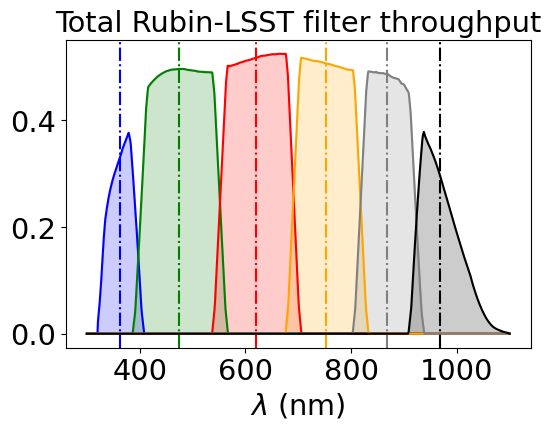

In [102]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(WL,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(WL,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total Rubin-LSST filter throughput")

In [103]:
#from lsst.summit.utils.utils import checkStackSetup
#checkStackSetup()

In [104]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208/20231220T142452Z
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221/20231221T125249Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2/20231208T100936Z
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2/20231208T130352Z


## Smooth

In [105]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

## Config

### Config collection

In [106]:
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

# all spectra from September 2022 to december 2023
#the reconstruction done by  LambdaMin = 350.0 and spectractor v3.0.3 in 2023/12/21
my_collection = "u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221"

### Config Auxtel

In [107]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_path = "/home/d/dagoret/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [108]:
load_config(config_fullpath)

### Config Telescope Throughtput

In [109]:
throughput_fullpath = os.path.join(spectractor.__path__[0],parameters.THROUGHPUT_DIR)
throughput_fullfilename = os.path.join(throughput_fullpath,throughput_filename)

In [110]:
tel_lambdas, tel_thr, tel_errthr = load_transmission(throughput_fullfilename) 

In [111]:
parameters.THROUGHPUT_DIR = throughput_fullpath 
parameters.OBS_FULL_INSTRUMENT_TRANSMISSON = throughput_filename
print(parameters.THROUGHPUT_DIR )
print(parameters.OBS_FULL_INSTRUMENT_TRANSMISSON)

/home/d/dagoret/repos/repos_w_2023_44/Spectractor/lib/python/spectractor/simulation/AuxTelThroughput/
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [112]:
%matplotlib inline
tel = TelescopeTransmission()
tel.plot_transmission()

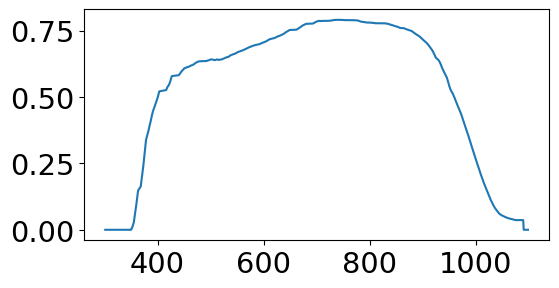

In [113]:
%matplotlib inline
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,tel.transmission(tel_lambdas))

### Config disperser

In [114]:
disp = dispersers.Hologram("holo4_003")

## Load config filename for Auxtel

In [115]:
load_config(config_fullpath)

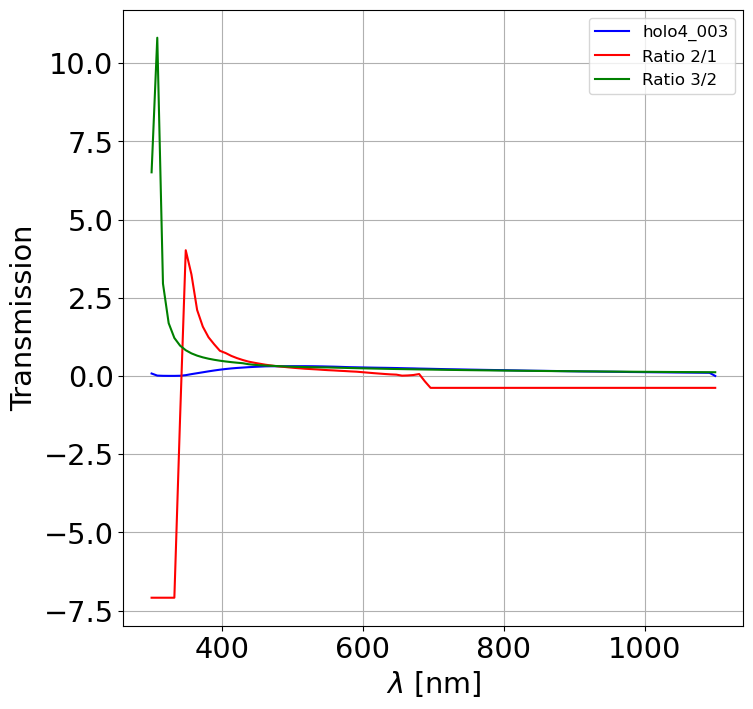

In [116]:
disp.plot_transmission()

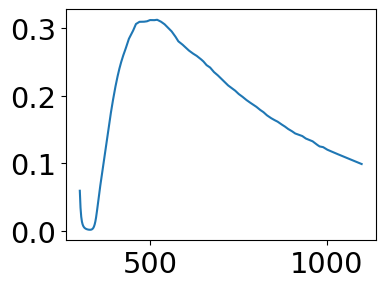

In [117]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,disp.transmission(tel_lambdas))

## Check the presence of the spectra

### select the date of observation

In [118]:
#DATEOBS = 20231207 # studied 2023/12/12
#DATEOBS = 20231206 # studied 2023/12/18
#DATEOBS = 20231205 # studied 2023/12/18
#DATEOBS = 20231204 # studied 2023/12/18
#DATEOBS = 20231130 # studied 2023/12/18
#DATEOBS = 20231129 # studied 2023/12/18
#DATEOBS = 20231128 # studied 2023/12/18
#DATEOBS = 20231127 # studied 2023/12/18




#DATEOBS = 20230801 # studied 2024/01/07 Very bad Spectra, really No
DATEOBS = 20230802 # studied 2024/01/07
#DATEOBS = 20230803 # No Spectra
#DATEOBS = 20230829 # studied 2024/01/07 Strange Spectra to check

### Fitted param file output name

- Note each date is overwritted inside the hdf5 file

In [119]:
#fitted_paramfile = f"fitted_atmparamfile_{DATEOBS}.hdf5"
fitted_paramfile = "fitted_atmparamfile.hdf5"

## Access to spectra using the butler

In [120]:
where = f"instrument='LATISS' and visit.day_obs={DATEOBS}" 
#where = "instrument='LATISS' "
records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
# records = list(butler.registry.queryDimensionRecords('visit', datasets='raw', where=where))

In [121]:
print(">>> Number of records : ",len(records))
records[-1]

>>> Number of records :  43


visit.RecordClass(instrument='LATISS', id=2023080200604, physical_filter='empty~holo4_003', name='AT_O_20230802_000604', day_obs=20230802, seq_num=604, exposure_time=30.0, target_name='HD14943', observation_reason='generic', science_program='spec', azimuth=136.03380973654401, zenith_angle=64.98242017468188, region=ConvexPolygon([UnitVector3d(0.5100879417503016, 0.36584746856090405, -0.7784381294801271), UnitVector3d(0.5093286012637872, 0.36778397731579776, -0.7780227001601218), UnitVector3d(0.510960793702244, 0.3681564004191616, -0.7767753421225334), UnitVector3d(0.5117201341092127, 0.36621989163283486, -0.777190771509598)]), timespan=Timespan(begin=astropy.time.Time('2023-08-03 04:34:33.836012', scale='tai', format='iso'), end=astropy.time.Time('2023-08-03 04:35:04.070000', scale='tai', format='iso')))

### List first of first records

In [122]:
first_seqnum = []

for i, r in enumerate(records):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",r.id)
    print("day_obs..................:",r.day_obs)
    print("target..................:",r.target_name)
    print("filt+disp..................:",r.physical_filter)
    seqnum = r.id-r.day_obs*100000
    print("seqnum ....................:",seqnum)
    first_seqnum.append(seqnum)

    # spec = butler.get('spectractorSpectrum', visit=r.id, detector=0, collections=my_collection, instrument='LATISS')
    
    if i>5:
        break

============= (0) ============datasetType = spectraction ============================================
fullId..................: 2023080200279
day_obs..................: 20230802
target..................: HD146233
filt+disp..................: empty~holo4_003
seqnum ....................: 279
============= (1) ============datasetType = spectraction ============================================
fullId..................: 2023080200280
day_obs..................: 20230802
target..................: HD146233
filt+disp..................: empty~holo4_003
seqnum ....................: 280
============= (2) ============datasetType = spectraction ============================================
fullId..................: 2023080200283
day_obs..................: 20230802
target..................: HD146233
filt+disp..................: empty~holo4_003
seqnum ....................: 283
============= (3) ============datasetType = spectraction ============================================
fullId..................:

In [123]:
# delete a collection
# butler.pruneDatasets(datasetRefs, disassociate=True, unstore=True, purge=True)

## Load one spectrum

In [124]:
sel_seqnum = first_seqnum[-3] 

In [125]:
dataId = {"day_obs": DATEOBS, "seq_num": sel_seqnum, 'instrument':'LATISS',"detector": 0}
spec= butler.get('spectractorSpectrum',dataId,collections=my_collection)
p = butler.get('spectrumLibradtranFitParameters',dataId,collections=my_collection)
p

FitParameters(values=array([1.17591290e+00, 0.00000000e+00, 1.00000000e-01, 1.74581406e-01,
       3.36268243e+02, 2.27375566e+00, 2.30342378e+00, 1.86902238e+02,
       1.13164277e+00, 0.00000000e+00]), labels=['A1', 'A2', 'VAOD', 'angstrom_exp', 'ozone [db]', 'PWV [mm]', 'reso [pix]', 'D_CCD [mm]', 'alpha_pix [pix]', 'B'], axis_names=['$A_1$', '$A_2$', 'VAOD', '$\\"a$', 'ozone [db]', 'PWV [mm]', 'reso [pix]', '$D_{CCD}$ [mm]', '$\\alpha_{\\mathrm{pix}}$ [pix]', '$B$'], bounds=[[0, 2], [0, 20.0], [0, 0.1], [0, 3], [0.0, 600.0], [0.0, 10.0], [0.1, 10], [185.16186740978125, 189.16186740978125], [-2, 2], [-inf, inf]], fixed=[False, True, True, False, False, False, False, False, True, True], truth=None, filename='', extra=None)

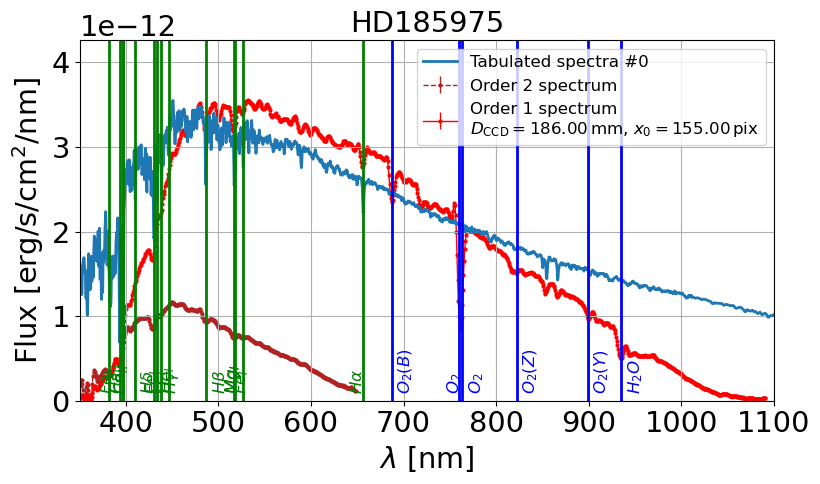

In [126]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
_ = spec.plot_spectrum(force_lines=True,ax=ax)

## Load all 1D spectrum and fitted atmospheric parameters

Three kind of informations:
 - 1D Spectrum : ``spectractorSpectrum``
 - atmospheric parameters fitted on 1D spectrum ``spectrumLibradtranFitParameters``
 - atmospheric parameters fitted on Spectrogram ``spectrogramLibradtranFitParameters``

In [127]:
params_spectrum = []
params_spectrogram = []
times = []
headers = []
spectra = []

for i, r in enumerate(records):
    try:
        times.append(r.day_obs)
        spec =  butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        headers.append(spec.header)
        spectra.append(spec)
        p = butler.get('spectrumLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        params_spectrum.append(p)
        p = butler.get('spectrogramLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        params_spectrogram.append(p)
    #except ValueError:
    except Exception as inst:
        except_type = type(inst)
        except_args = inst.args
        print("catch exception ", inst, "type =",except_type, "args = ",except_args) 
        print("\t >>>>> Skip record ", r.id)
        continue

In [128]:
r.timespan

Timespan(begin=astropy.time.Time('2023-08-03 04:34:33.836012', scale='tai', format='iso'), end=astropy.time.Time('2023-08-03 04:35:04.070000', scale='tai', format='iso'))

In [129]:
r.zenith_angle

64.98242017468188

In [130]:
len(params_spectrogram)

43

## Filtering data

In [131]:
def select_files(collection, where):
    """
    Select all records according the where clause
    """
    # datasetRefs = registry.queryDatasets(datasetType='spectractorSpectrum', collections=my_collection, where=where)
    #records = list(butler.registry.queryDimensionRecords('exposure', where=where))
    records = list(butler.registry.queryDimensionRecords('exposure', datasets='spectractorSpectrum', where=where,  collections=collection))
    records = sorted(records, key=lambda x: x.id, reverse=False)
    return records

def filter_data(records, sigma_clip=3):  # pragma: no cover
    """
    Spectrum reconstruction Quality Selection
    """
    from scipy.stats import median_abs_deviation
    D = []
    chi2 = []
    dx = []
    amplitude = []
    regs = []
    times = []
    specs = []
    alpha_0_2 = []
    #parameters.VERBOSE = False
    #parameters.DEBUG = False
    for i, r in enumerate(records):
        times.append(r.day_obs)
        spec = butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        spec.dataId = r.id
        if spec.x0[0] > 500: 
            continue
        D.append(spec.header["D2CCD"])
        dx.append(spec.header["PIXSHIFT"])
        regs.append(np.log10(spec.header["PSF_REG"]))
        amplitude.append(np.sum(np.abs(spec.data[300:])))
        # if "CHI2_FIT" in header:
        chi2.append(spec.header["CHI2_FIT"])
        specs.append(spec)
        p = butler.get('spectrumForwardModelFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        alpha_0_2.append(p.values[p.get_index("alpha_0_2")])
        #except:
        #    new_file_names.remove(name)
        #    print(f"fail to open {name}. len(file_names)={len(new_file_names)}")
    params = {'D2CCD': np.array(D),
              'dx': np.array(dx),
              'regs': np.array(regs),
              'chi2': np.array(chi2),
              'amplitude': np.array(amplitude),
              'alpha_0_2': np.array(alpha_0_2)
             }
    k = np.arange(len(D))
    filter_indices = np.ones_like(k, dtype=bool)
    for par in params.keys():
        if par in ['amplitude']: #, 'alpha_0_2']:
            continue
        filter_indices *= np.logical_and(params[par] > np.median(params[par]) - sigma_clip * median_abs_deviation(params[par]),
                                         params[par] < np.median(params[par]) + sigma_clip * median_abs_deviation(params[par]))
    for par in params.keys():
        fig = plt.figure(figsize=(8,4))
        plt.plot(k, params[par])
        plt.plot(k[filter_indices], params[par][filter_indices], "ko")
        plt.grid()
        plt.title(par)

        suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
        plt.suptitle(suptitle,fontsize=10,y=1.00)
        plt.show()
    return [s for i,s in enumerate(specs) if filter_indices[i]]


def plot_spectra(spectra, colorparams):
    """
    plot spectra
    """

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    all_target_names = [] 

    fig  = plt.figure(figsize=(11,6))
    for spec in spectra:
        target_name = spec.target.label
        if target_name in all_target_names:
            plt.plot(spec.lambdas, spec.data, color = colormap(normalize(spec.airmass)))
        else:
            plt.plot(spec.lambdas, spec.data, color = colormap(normalize(spec.airmass)),label=target_name)
            all_target_names.append(target_name)
            
    plt.grid()
    plt.xlabel("$\lambda$ [nm]")
    plt.ylabel(f"Flux [{spec.units}]")
    plt.legend()
    
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    cbar.set_label("Airmass $z$")
    title = f"Observations : {DATEOBS}"
    suptitle = f"collection = {my_collection}"
    plt.title(title)
    plt.suptitle(suptitle,fontsize=10)
    plt.show()
    return fig



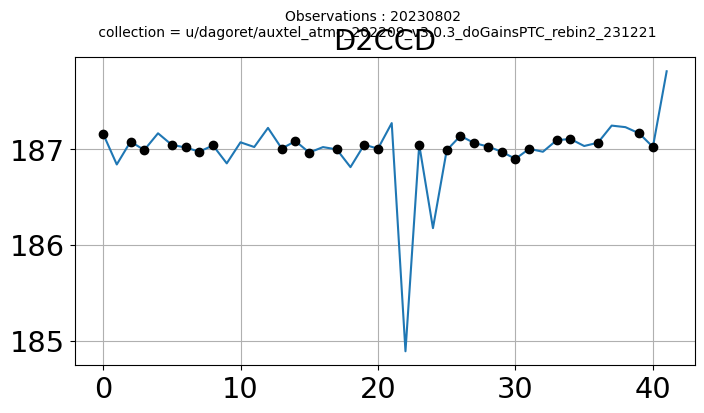

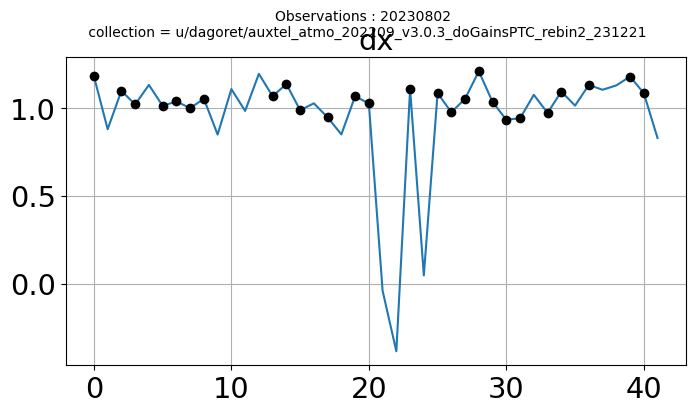

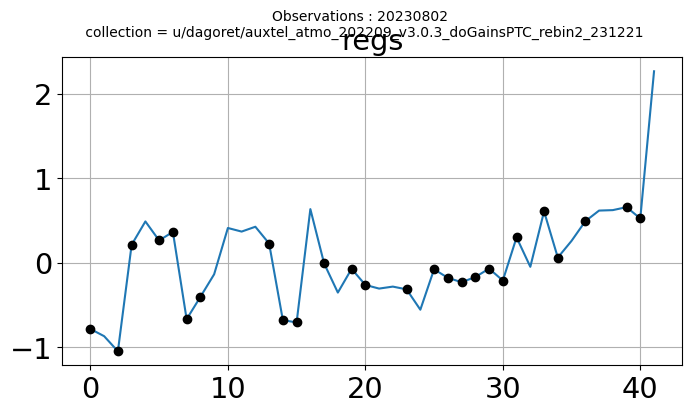

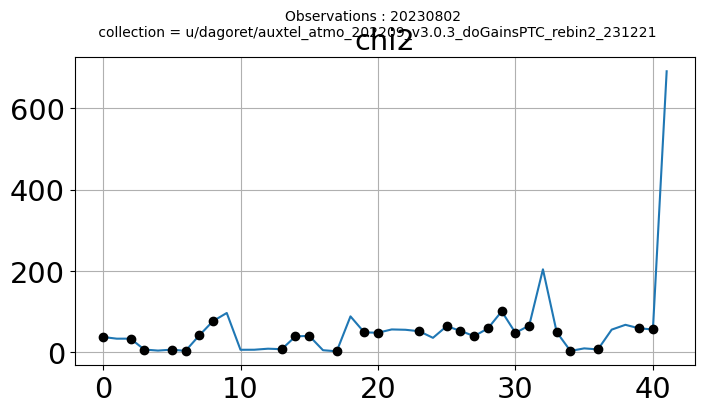

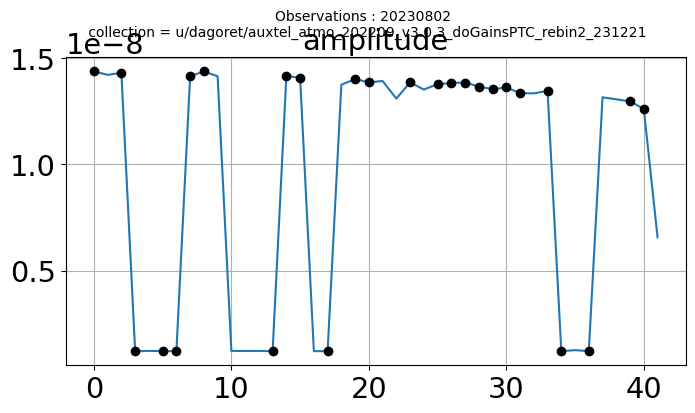

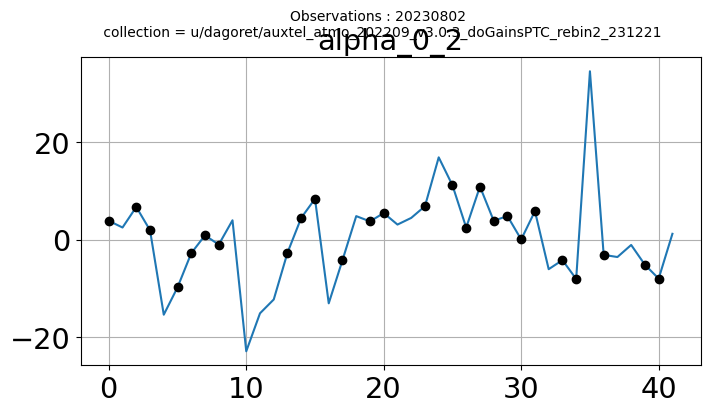

In [132]:
spectra_filtered = filter_data(records)

## Time

In [133]:
spectra_filtered[0].dataId

2023080200279

In [134]:
spectra_filtered[0].date_obs

'2023-08-02T23:14:19.251990723Z'

In [135]:
all_date_obs = [spec.date_obs for spec in spectra_filtered ]
all_date_obs

['2023-08-02T23:14:19.251990723Z',
 '2023-08-02T23:16:48.498007604Z',
 '2023-08-03T00:45:37.903003734Z',
 '2023-08-03T00:48:12.865007321Z',
 '2023-08-03T00:48:55.877006141Z',
 '2023-08-03T01:06:31.328502699Z',
 '2023-08-03T01:12:51.904498235Z',
 '2023-08-03T01:41:07.702508532Z',
 '2023-08-03T01:49:30.616997550Z',
 '2023-08-03T01:58:51.207497030Z',
 '2023-08-03T02:19:53.079009032Z',
 '2023-08-03T02:31:42.806509778Z',
 '2023-08-03T02:34:36.511502698Z',
 '2023-08-03T02:49:26.187007192Z',
 '2023-08-03T02:58:31.065498394Z',
 '2023-08-03T02:59:14.069502759Z',
 '2023-08-03T03:02:01.039002661Z',
 '2023-08-03T03:10:34.385993181Z',
 '2023-08-03T03:17:52.494994090Z',
 '2023-08-03T03:20:44.826492221Z',
 '2023-08-03T03:42:46.727006481Z',
 '2023-08-03T03:46:20.494491417Z',
 '2023-08-03T03:53:45.311992674Z',
 '2023-08-03T03:56:34.314991479Z',
 '2023-08-03T04:23:38.697505339Z',
 '2023-08-03T04:27:13.508498003Z']

In [136]:
all_date_mjd = [Time(spec.date_obs).mjd   for spec in spectra_filtered ]
all_date_mjd

[60158.96827837952,
 60158.97000576398,
 60159.03168869217,
 60159.033482233885,
 60159.03398005794,
 60159.04619593175,
 60159.05060074651,
 60159.07022803829,
 60159.076048807845,
 60159.08253712381,
 60159.09714211816,
 60159.10535655683,
 60159.10736703128,
 60159.11766420147,
 60159.12397066549,
 60159.12446839702,
 60159.126400914385,
 60159.13234243048,
 60159.13741313651,
 60159.13940771403,
 60159.1547074885,
 60159.15718164921,
 60159.16232999991,
 60159.16428605314,
 60159.183086776684,
 60159.18557301502]

In [137]:
N = len(all_date_mjd)
for idx in range(0,N-1):
    print((all_date_mjd[idx+1] -  all_date_mjd[idx])*60)

0.10364306741394103
3.700975691608619
0.10761250276118517
0.029869443242205307
0.7329524285160005
0.26428888566442765
1.1776375069166534
0.3492461732821539
0.3892989578889683
0.8762996610312257
0.49286632012808695
0.12062846726621501
0.6178302111220546
0.37838784119230695
0.02986389197758399
0.11595104180742055
0.35649096564156935
0.3042423617444001
0.11967465121415444
0.9179864684119821
0.14844964229268953
0.3089010422991123
0.11736319385818206
1.1280434124637395
0.14917430016794242


In [138]:
N = len(all_date_mjd)
for idx in range(0,N-1):
    print((all_date_mjd[idx+1] -  all_date_mjd[0])*60)

0.10364306741394103
3.80461875902256
3.912231261783745
3.9421007050259504
4.675053133541951
4.939342019206379
6.116979526123032
6.466225699405186
6.855524657294154
7.73182431832538
8.224690638453467
8.345319105719682
8.963149316841736
9.341537158034043
9.371401050011627
9.487352091819048
9.843843057460617
10.148085419205017
10.267760070419172
11.185746538831154
11.334196181123843
11.643097223422956
11.760460417281138
12.888503829744877
13.03767812991282


### Plot Spectra

/tmp/ipykernel_13667/2290022125.py:108: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


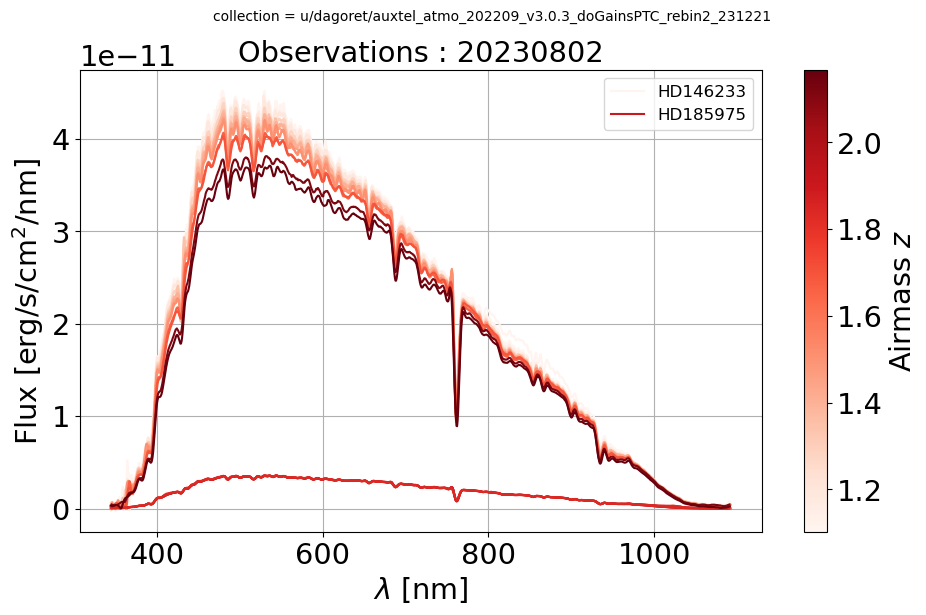

In [139]:
fig = plot_spectra(spectra_filtered, [spec.airmass for spec in spectra_filtered])

### Targets

In [140]:
list_of_targets = np.unique([spec.target.label for spec in spectra_filtered])
print(">>> List of targets ",list_of_targets)

>>> List of targets  ['HD146233' 'HD185975']


In [141]:
import getCalspec.getCalspec as gcal

In [142]:
all_calspecs = {}
for target_name in list_of_targets:
    c =  gcal.Calspec(target_name) 
    all_calspecs[target_name] = c.get_spectrum_numpy() 

In [143]:
#all_calspecs["HD185975"].keys()

In [144]:
all_calspecs.keys()

dict_keys(['HD146233', 'HD185975'])

(3000.0, 10000.0)

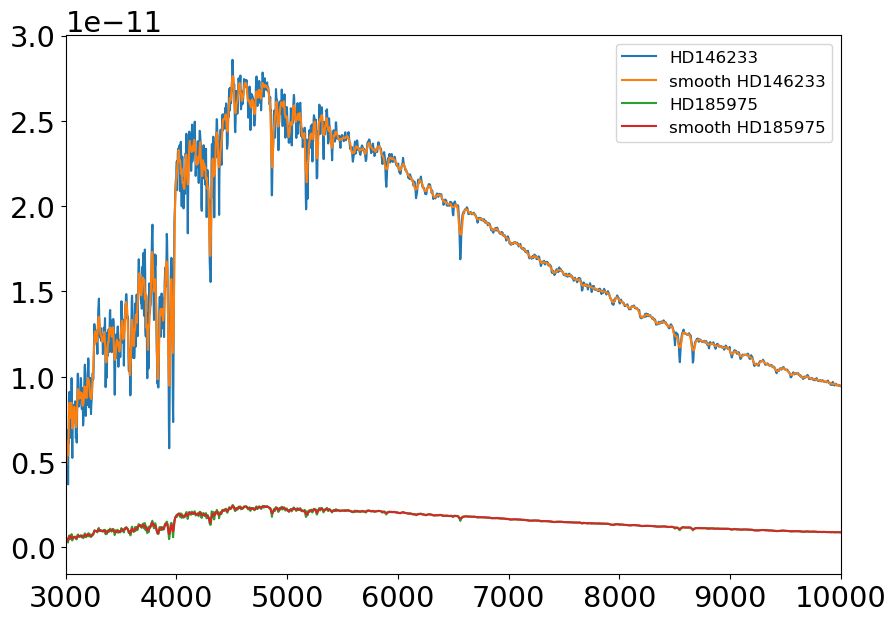

In [145]:
all_calspecs_sm = {}
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()
span = 3
for target_name in list_of_targets:
    c_dict = all_calspecs[target_name]
    wls = c_dict["WAVELENGTH"].value
    sed = c_dict["FLUX"].value
    ax.plot(wls,sed,label=target_name)
    
    sedm = smooth_data_np_convolve(sed,span)
    c_dict_sm = {"WAVELENGTH":wls,"FLUX":sedm}
    all_calspecs_sm[target_name] = c_dict_sm
    ax.plot(wls,sedm,label="smooth " +target_name)
ax.legend()
ax.set_xlim(3000.,10000.)    

In [146]:
c_dict["WAVELENGTH"].value

array([  1710.563477,   1711.934326,   1713.305298, ..., 318329.84375 ,
       318604.8125  , 318878.78125 ])

## Plot ratio

In [147]:
def plot_atmtransmission(spectra, colorparams):
    """
    plot spectra
    """

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 
   

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    all_shown_target_names = [] 
    
    fig  = plt.figure(figsize=(11,6))
    for spec in spectra:
        
        
        target_name = spec.target.label

        wls = spec.lambdas
        flx = spec.data
        flx_err = spec.err
        
        #c_dict = all_calspecs[target_name]
        c_dict = all_calspecs_sm[target_name]

        #smooth_data_np_convolve(sed,span)
        
        sed=np.interp(wls, c_dict["WAVELENGTH"]/10.,c_dict["FLUX"]*10.,left=1e-15,right=1e-15)
       
                     
        ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
       
        indexes = np.where(np.logical_and(wls>350.,wls<=1000.))[0]
       
        sel_wls = wls[indexes]
        sel_ratio = ratio[indexes]
        
        if target_name in all_shown_target_names:
            plt.plot(sel_wls, sel_ratio, color = colormap(normalize(spec.airmass)))
        else:
            plt.plot(sel_wls,sel_ratio, color = colormap(normalize(spec.airmass)),label=target_name)
            all_shown_target_names.append(target_name)
            
     
            
    plt.grid()
    plt.xlabel("$\lambda$ [nm]")
    #plt.ylabel(f"Flux [{spec.units}]")
    plt.legend()
    plt.xlim(360.,1000.)  
    plt.ylim(0.,1.2)  
    
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    cbar.set_label("Airmass $z$")
    title = f"Atmospheric transmission at target airmasses)"
    suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
    plt.title(title)
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.show()
    



In [148]:
def plot_atmtransmission_zcorr(spectra, colorparams):
    """
    plot spectra
    """

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 
   

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    all_shown_target_names = [] 
    
    fig  = plt.figure(figsize=(11,6))
    for spec in spectra:
        
        
        target_name = spec.target.label

        wls = spec.lambdas
        flx = spec.data
        flx_err = spec.err
        
        #c_dict = all_calspecs[target_name]
        c_dict = all_calspecs_sm[target_name]

        #smooth_data_np_convolve(sed,span)
        
        sed=np.interp(wls, c_dict["WAVELENGTH"]/10.,c_dict["FLUX"]*10.,left=1e-15,right=1e-15)
       
                     
        ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
       
        indexes = np.where(np.logical_and(wls>350.,wls<=1000.))[0]
       
        sel_wls = wls[indexes]
        sel_ratio = ratio[indexes]
        sel_ratio_airmas_corr = np.power(sel_ratio,1/spec.airmass)
        
        if target_name in all_shown_target_names:
            plt.plot(sel_wls, sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)))
        else:
            plt.plot(sel_wls,sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)),label=target_name)
            all_shown_target_names.append(target_name)
            
     
            
    plt.grid()
    plt.xlabel("$\lambda$ [nm]")
    #plt.ylabel(f"Flux [{spec.units}]")
    plt.legend()
    plt.xlim(360.,1000.)  
    plt.ylim(0.,1.2)  
    
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    cbar.set_label("Airmass $z$")
    title = f"Atmospheric transmission scaled for airmass=1)"
    suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
    plt.title(title)
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.show()
    



/tmp/ipykernel_13667/2286372081.py:34: RuntimeWarning: divide by zero encountered in divide
  ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
/tmp/ipykernel_13667/2286372081.py:65: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


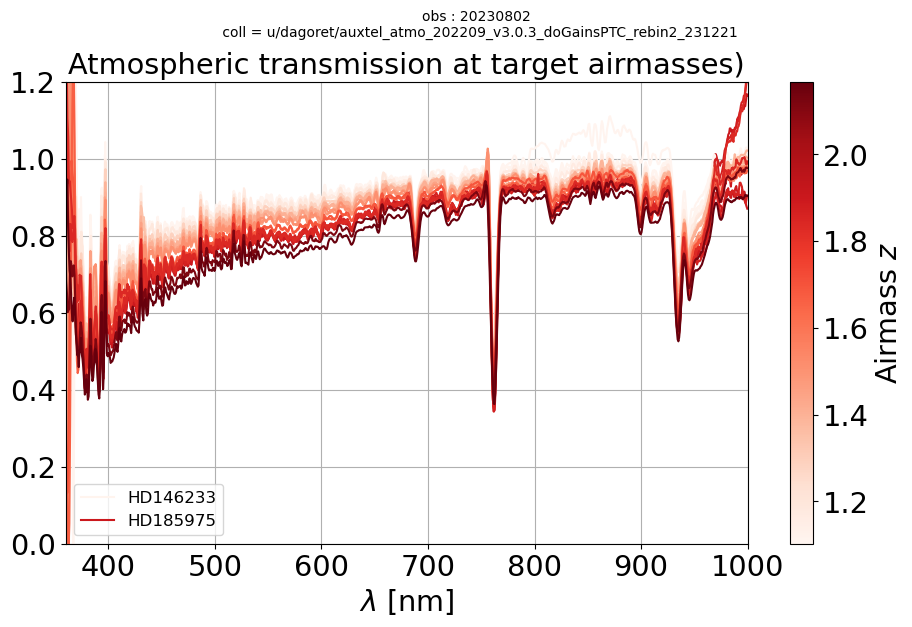

In [149]:
plot_atmtransmission(spectra_filtered, [spec.airmass for spec in spectra_filtered])

/tmp/ipykernel_13667/2552018270.py:34: RuntimeWarning: divide by zero encountered in divide
  ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
/tmp/ipykernel_13667/2552018270.py:40: RuntimeWarning: invalid value encountered in power
  sel_ratio_airmas_corr = np.power(sel_ratio,1/spec.airmass)
/tmp/ipykernel_13667/2552018270.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


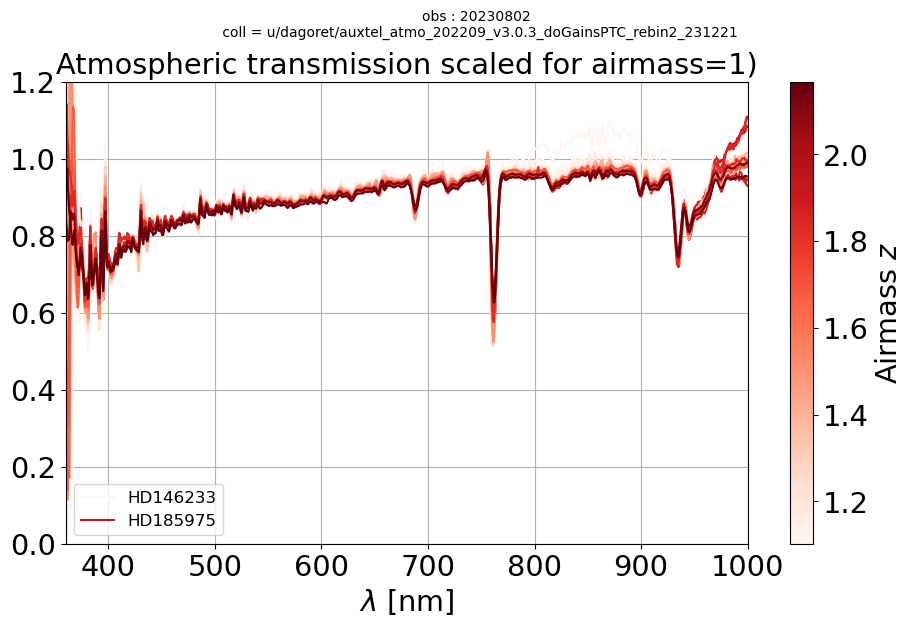

In [150]:
plot_atmtransmission_zcorr(spectra_filtered, [spec.airmass for spec in spectra_filtered])

## Atmospheric simulation

In [151]:
from getObsAtmo.getObsAtmo import ObsAtmo

In [152]:
def plot_atmtransmission_zcorr_antatmsim(spectra, colorparams,am=1,pwv=2,oz=300,vaod=0.01,grey=0.1):
    """
    plot spectra
    """

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 

    all_meas_atmtransmissions = []

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    all_shown_target_names = [] 
    
    fig  = plt.figure(figsize=(11,6))
    for spec in spectra:
        
        
        target_name = spec.target.label

        wls = spec.lambdas
        flx = spec.data
        flx_err = spec.err
        
        #c_dict = all_calspecs[target_name]
        c_dict = all_calspecs_sm[target_name]

        #smooth_data_np_convolve(sed,span)
        
        sed=np.interp(wls, c_dict["WAVELENGTH"]/10.,c_dict["FLUX"]*10.,left=1e-15,right=1e-15)
       
                     
        ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
       
        indexes = np.where(np.logical_and(wls>350.,wls<=1000.))[0]
       
        sel_wls = wls[indexes]
        sel_ratio = ratio[indexes]
        sel_ratio_airmas_corr = np.power(sel_ratio,am/spec.airmass)/(np.power(grey,am))
        
        if target_name in all_shown_target_names:
            plt.plot(sel_wls, sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)))
        else:
            plt.plot(sel_wls,sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)),label=target_name)
            all_shown_target_names.append(target_name)

        all_meas_atmtransmissions.append((sel_wls,sel_ratio_airmas_corr))
    
    textstr = '\n'.join((
    r'$am=%.2f$' % (am, ),
    r'$pwv=%.2f$ mm' % (pwv, ),
    r'$ozone=%.1f$ DU' % (oz, ),
    r'$vaod=%.3f$' % (vaod,)))
    emul1 =  ObsAtmo("AUXTEL",740.)
    emul2 =  ObsAtmo("AUXTEL",730.)
    transm_sim1 = emul1.GetAllTransparencies(sel_wls,am,pwv,oz,tau=vaod)
    transm_sim2 = emul2.GetAllTransparencies(sel_wls,am,pwv,oz,tau=vaod)
    
    plt.plot(sel_wls,transm_sim1,'-b',label=f"simulation P=740. hPa")
    plt.plot(sel_wls,transm_sim2,'-',label=f"simulation P=730. hPa")

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.70, 0.25, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
            
    plt.grid()
    plt.xlabel("$\lambda$ [nm]")
    #plt.ylabel(f"Flux [{spec.units}]")
    plt.legend()
    plt.xlim(360.,1000.)  
    plt.ylim(0.,1.2)  
    
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    cbar.set_label("Airmass $z$")
    title = f"Atmospheric transmission scaled for airmass={am})"
    suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
    plt.title(title)
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.show()
    return all_meas_atmtransmissions
    



## Need to get average atmospheric parameters

In [153]:
#f_atmparamfitted  = h5py.File(fitted_paramfile, 'a') 
#g = f_atmparamfitted.create_group(str(DATEOBS))

FLAG_KEYS_FOUND = False
FLAG_FITTEDPARAM_FOUND = False
datetag_str = str(DATEOBS)

try:
    with h5py.File(fitted_paramfile, mode='r') as f_atmparamfitted:
        all_keys = list(f_atmparamfitted.keys())
        FLAG_KEYS_FOUND = True
        print("all keys found ",all_keys)

        if datetag_str in all_keys:
        # read all keys already registered    
            list_of_attributes = f_atmparamfitted[datetag_str].attrs.keys()
            print(list_of_attributes)
            FLAG_FITTEDPARAM_FOUND = True
            dict_attributes = {}
            for attr_name in list_of_attributes:
                dict_attributes[attr_name] = f_atmparamfitted[datetag_str].attrs[attr_name]
                
            print( dict_attributes)
        
        f_atmparamfitted.close()
except (KeyError, TypeError, FileNotFoundError):
    FLAG_KEYS_FOUND = False
    f_atmparamfitted.close()

all keys found  ['20230802']
<KeysViewHDF5 ['A1_x', 'PWV [mm]_x', 'VAOD_x', 'ozone [db]_x']>
{'A1_x': 1.0053972700704723, 'PWV [mm]_x': 2.3245866012030336, 'VAOD_x': 0.022333997858809712, 'ozone [db]_x': 265.3712812220796}


In [154]:
FLAG_FITTEDPARAM_FOUND

True

In [155]:
if FLAG_FITTEDPARAM_FOUND:
    pwv0 = dict_attributes['PWV [mm]_x']
    grey0 = dict_attributes['A1_x']
    oz0 = dict_attributes['ozone [db]_x']
    vaod0 = dict_attributes['VAOD_x']
else:
    pwv0=2.02
    oz0=315.8
    vaod0=0.014
    grey0=0.963
    

AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


/tmp/ipykernel_13667/2087972685.py:35: RuntimeWarning: divide by zero encountered in divide
  ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
/tmp/ipykernel_13667/2087972685.py:41: RuntimeWarning: invalid value encountered in power
  sel_ratio_airmas_corr = np.power(sel_ratio,am/spec.airmass)/(np.power(grey,am))
/tmp/ipykernel_13667/2087972685.py:85: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


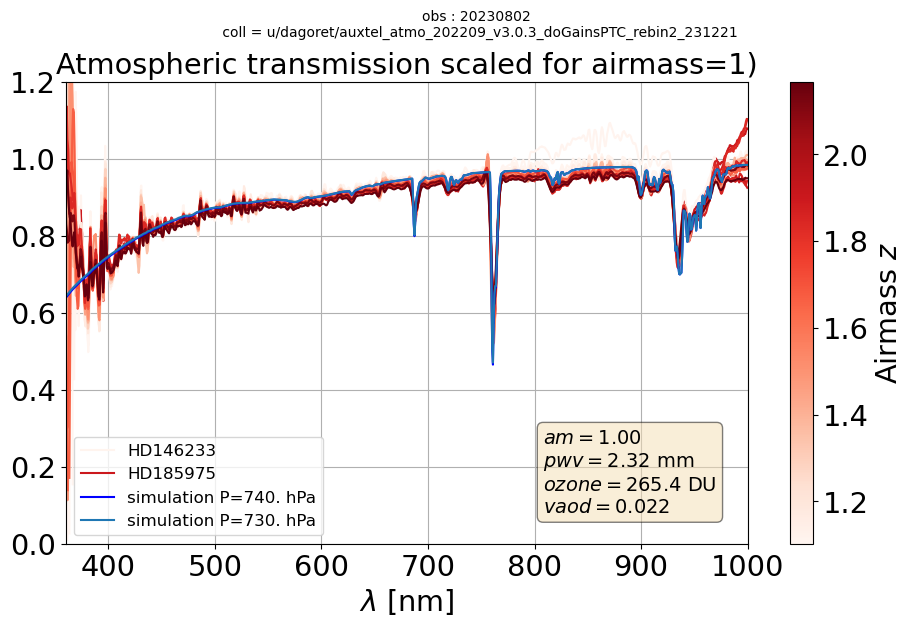

In [156]:
all_meas_atmtransmissions_z1 = plot_atmtransmission_zcorr_antatmsim(spectra_filtered, [spec.airmass for spec in spectra_filtered],am=1,pwv=pwv0,oz=oz0,vaod=vaod0,grey=grey0)

/tmp/ipykernel_13667/2087972685.py:35: RuntimeWarning: divide by zero encountered in divide
  ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
/tmp/ipykernel_13667/2087972685.py:41: RuntimeWarning: invalid value encountered in power
  sel_ratio_airmas_corr = np.power(sel_ratio,am/spec.airmass)/(np.power(grey,am))
/tmp/ipykernel_13667/2087972685.py:85: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


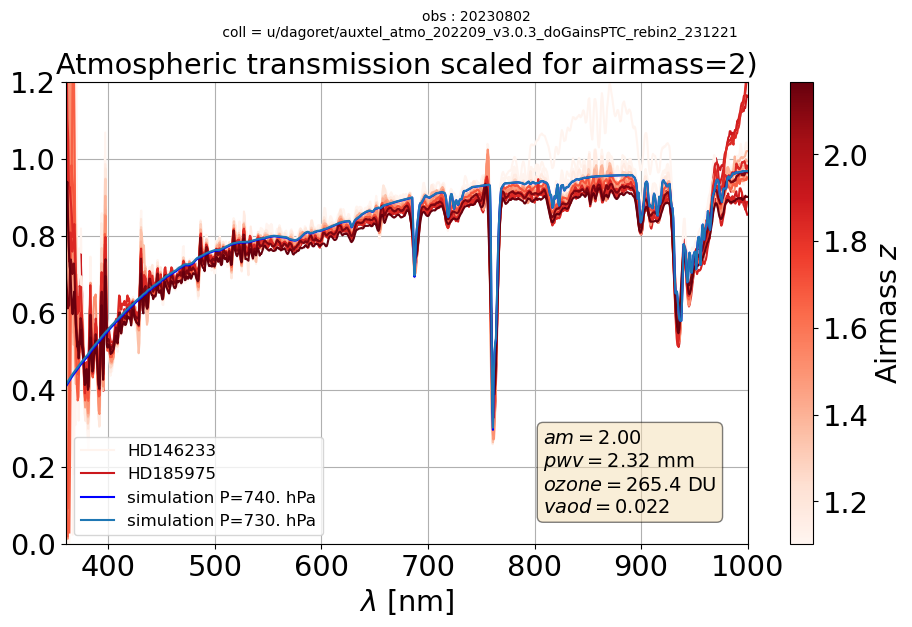

In [157]:
all_meas_atmtransmissions_z2 = plot_atmtransmission_zcorr_antatmsim(spectra_filtered, [spec.airmass for spec in spectra_filtered],am=2,pwv=pwv0,oz=oz0,vaod=vaod0,grey=grey0)

In [158]:
def plot_atmtransmission_zcorr_antatmsim_ratio(spectra, colorparams,am=1,pwv=2,oz=300,vaod=0.01,grey=0.1):
    """
    plot spectra
    """

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 
   

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    all_shown_target_names = [] 
    
    fig  = plt.figure(figsize=(14,10))

    grid = gridspec.GridSpec(2, 1, height_ratios=[2.5,1])

    ax1 = plt.subplot(grid[0])
    ax2 = plt.subplot(grid[1],sharex=ax1)

    textstr = '\n'.join((
    r'$am=%.2f$' % (am, ),
    r'$pwv=%.2f$ mm' % (pwv, ),
    r'$ozone=%.1f$ DU' % (oz, ),
    r'$vaod=%.3f$' % (vaod,)))
    emul1 =  ObsAtmo("AUXTEL",740.)
    emul2 =  ObsAtmo("AUXTEL",730.)
    


    for spec in spectra:
        
        
        target_name = spec.target.label

        wls = spec.lambdas
        flx = spec.data
        flx_err = spec.err
        
        #c_dict = all_calspecs[target_name]
        c_dict = all_calspecs_sm[target_name]

        #smooth_data_np_convolve(sed,span)
        
        sed=np.interp(wls, c_dict["WAVELENGTH"]/10.,c_dict["FLUX"]*10.,left=1e-15,right=1e-15)
       
                     
        ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
       
        indexes = np.where(np.logical_and(wls>350.,wls<=1000.))[0]
       
        sel_wls = wls[indexes]
        sel_ratio = ratio[indexes]
        sel_ratio_airmas_corr = np.power(sel_ratio,am/spec.airmass)/(np.power(grey,am))
        
        if target_name in all_shown_target_names:
            ax1.plot(sel_wls, sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)))
        else:
            ax1.plot(sel_wls,sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)),label=target_name)
            all_shown_target_names.append(target_name)

        transm_sim1 = emul1.GetAllTransparencies(sel_wls,am,pwv,oz,tau=vaod)
        transm_sim2 = emul2.GetAllTransparencies(sel_wls,am,pwv,oz,tau=vaod)
    
        ax1.plot(sel_wls,transm_sim1,'-b')
        ax1.plot(sel_wls,transm_sim2,'-g')

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
   
        # place a text box in upper left in axes coords

        ax2.plot(sel_wls,sel_ratio_airmas_corr/transm_sim1,color = colormap(normalize(spec.airmass)),label=f"simulation P=740. hPa")
        #ax2.plot(sel_wls,sel_ratio_airmas_corr/transm_sim2,'-g',label=f"simulation P=730. hPa")
        ax1.text(0.70, 0.25, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)
            
    ax1.grid()
    #ax1.set_xlabel("$\lambda$ [nm]")
    #plt.ylabel(f"Flux [{spec.units}]")
    ax1.legend()
    ax1.set_xlim(360.,1000.)  
    ax1.set_ylim(0.,1.2)  

    ax2.set_title(f"ratio spectrum/sim at airmass {am:.2f}")
    ax2.set_xlabel("$\lambda$ [nm]")  
    ax2.set_ylim(0.95,1.05)  
    ax2.grid()
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    #cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    #cbar.set_label("Airmass $z$")
    title = f"Atmospheric transmission scaled for airmass={am})"
    suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
    ax1.set_title(title)
    plt.suptitle(suptitle,fontsize=10,y=1.0)

    
    plt.show()
    



AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


/tmp/ipykernel_13667/1684027615.py:50: RuntimeWarning: divide by zero encountered in divide
  ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
/tmp/ipykernel_13667/1684027615.py:56: RuntimeWarning: invalid value encountered in power
  sel_ratio_airmas_corr = np.power(sel_ratio,am/spec.airmass)/(np.power(grey,am))


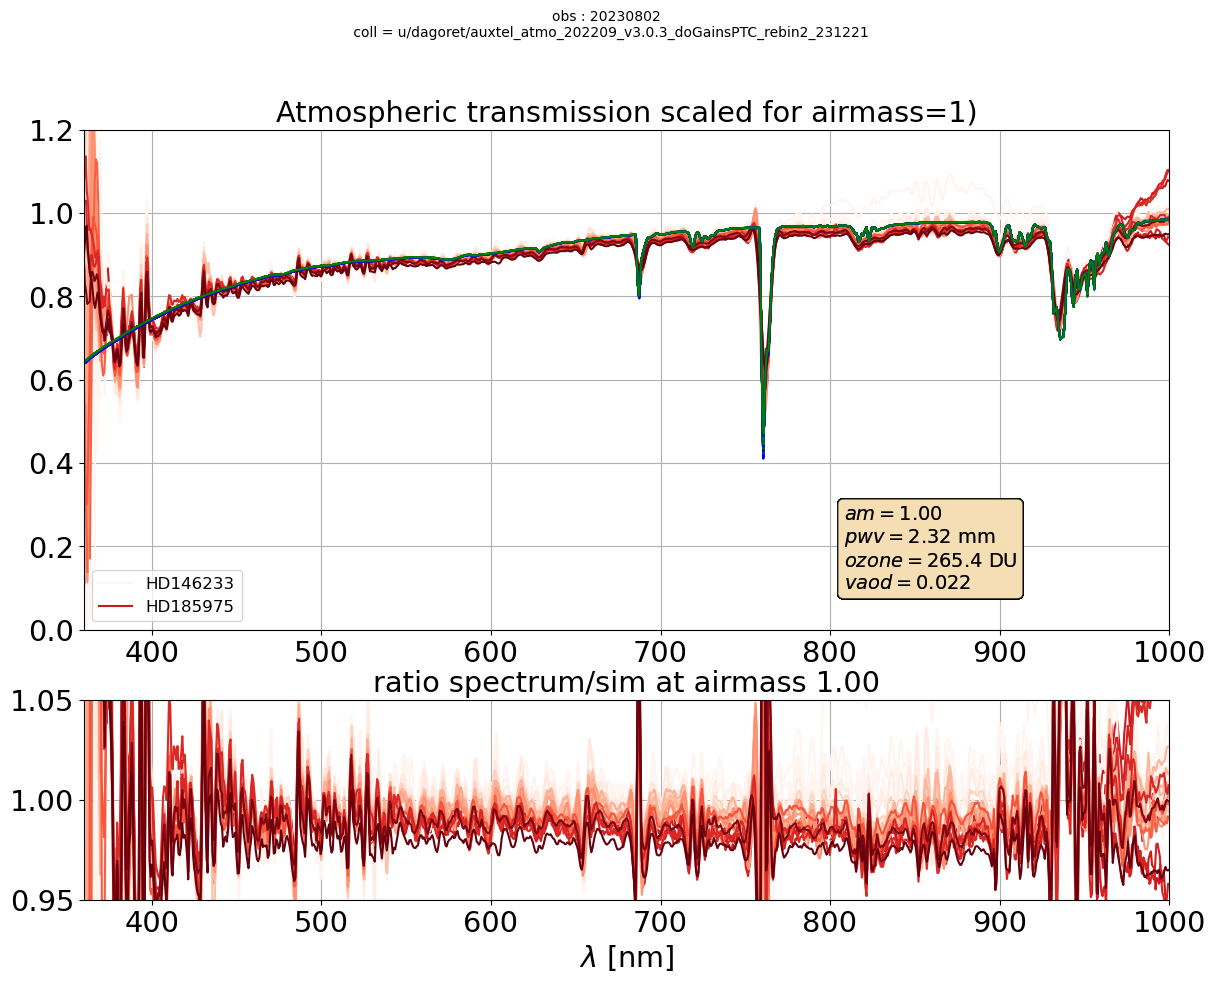

In [159]:
plot_atmtransmission_zcorr_antatmsim_ratio(spectra_filtered, [spec.airmass for spec in spectra_filtered],am=1,pwv=pwv0,oz=oz0,vaod=vaod0,grey=grey0)

## Compute total transmision and zero points

In [160]:
def compute_total_transm(filter,meas_atmtransm):
    """
    """
    N = len(meas_atmtransm)
    bd = bandpass_inst[filter]
    func = interpolate.interp1d(x=bd.wavelen, y=bd.sb ,fill_value="extrapolate")
    all_total_transm = []
    for idx in range(N):
        the_wl = meas_atmtransm[idx][0]
        the_atm = meas_atmtransm[idx][1]
        the_totaltrans = the_atm * func(the_wl)
        all_total_transm.append((the_wl,the_totaltrans))
    return all_total_transm

#### Compute total transmission

In [161]:
all_total_transm = {} 
for index,f in enumerate(filter_tagnames):
    all_total_transm[f] = compute_total_transm(f,all_meas_atmtransmissions_z1)

Text(0.5, 1.0, 'obs : 20230802 \n coll = u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221')

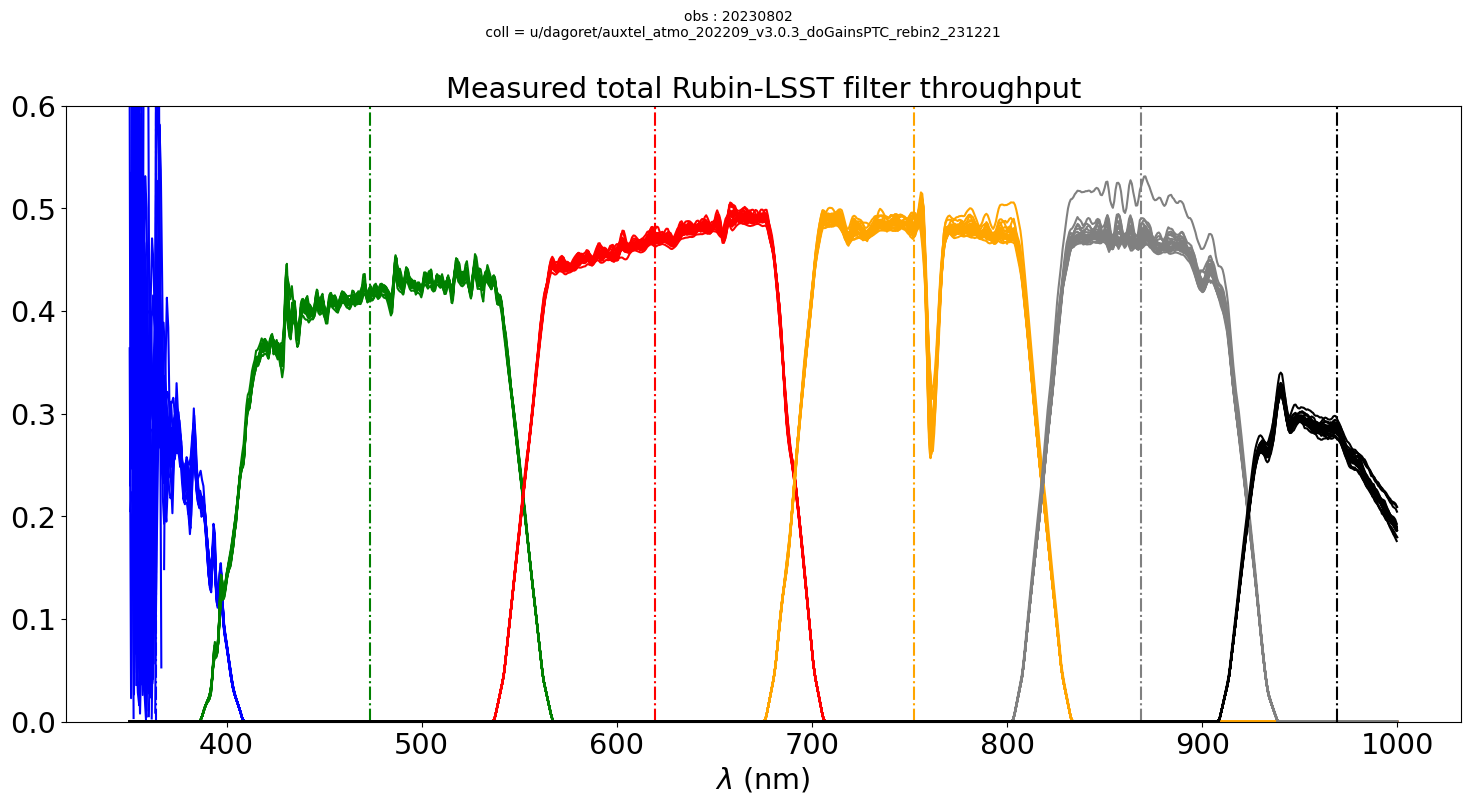

In [162]:
fig, axs = plt.subplots(1,1,figsize=(18,8))
for index,f in enumerate(filter_tagnames):
    
    N = len(all_total_transm[f])
    for idx in range(N):
        the_wl = all_total_transm[f][idx][0] 
        the_tottransm = all_total_transm[f][idx][1] 
        axs.plot(the_wl,the_tottransm ,color=filter_color[index])  
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Measured total Rubin-LSST filter throughput")
axs.set_ylim(0,0.6)
suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
plt.suptitle(suptitle,fontsize=10,y=1.0)

#### Compute II0 Integrals

also keep track of time

In [163]:
all_total_II0 = {} 
all_total_II0_mjd = {}

for index,f in enumerate(filter_tagnames):
    
    N = len(all_total_transm[f])
    all_II0 = np.zeros(N)
    all_II0_mjd = np.zeros(N)
    
    for idx in range(N):
        the_wl = all_total_transm[f][idx][0] 
        the_tottransm = all_total_transm[f][idx][1] 
        all_II0[idx] = fII0(the_wl,the_tottransm)
        all_II0_mjd[idx] = all_date_mjd[idx]

    all_total_II0[f] = all_II0
    all_total_II0_mjd[f] = all_II0_mjd

In [164]:
all_total_II0 

{'u': array([       nan,        nan, 0.04065316, 0.04254378, 0.03785214,
               nan,        nan, 0.04197236, 0.0410227 , 0.03657335,
        0.03776587, 0.0428748 , 0.03479962, 0.03648355, 0.03121653,
        0.03652751, 0.03080481, 0.03131444, 0.03018179, 0.03906793,
               nan, 0.03523681, 0.04029109, 0.04468228, 0.03695571,
        0.03472216]),
 'g': array([0.12968968, 0.12936361, 0.12887211, 0.12889944, 0.12839015,
        0.12851919, 0.12774708, 0.12880847, 0.12913857, 0.12954055,
        0.12836523, 0.12897422, 0.12917494, 0.12866282, 0.12863589,
        0.12876985, 0.12907505, 0.12866492, 0.12818581, 0.1287579 ,
        0.12827534, 0.1281243 , 0.12889812, 0.12950115, 0.12849923,
        0.12690193]),
 'r': array([0.10605279, 0.10622338, 0.10426473, 0.10437065, 0.10455213,
        0.10498131, 0.1045133 , 0.10405621, 0.1058239 , 0.10564433,
        0.104455  , 0.10551093, 0.10522813, 0.10507516, 0.10506277,
        0.10500837, 0.10544336, 0.10484957, 0.10455125, 0

In [165]:
all_total_II0_mjd

{'u': array([60158.96827838, 60158.97000576, 60159.03168869, 60159.03348223,
        60159.03398006, 60159.04619593, 60159.05060075, 60159.07022804,
        60159.07604881, 60159.08253712, 60159.09714212, 60159.10535656,
        60159.10736703, 60159.1176642 , 60159.12397067, 60159.1244684 ,
        60159.12640091, 60159.13234243, 60159.13741314, 60159.13940771,
        60159.15470749, 60159.15718165, 60159.16233   , 60159.16428605,
        60159.18308678, 60159.18557302]),
 'g': array([60158.96827838, 60158.97000576, 60159.03168869, 60159.03348223,
        60159.03398006, 60159.04619593, 60159.05060075, 60159.07022804,
        60159.07604881, 60159.08253712, 60159.09714212, 60159.10535656,
        60159.10736703, 60159.1176642 , 60159.12397067, 60159.1244684 ,
        60159.12640091, 60159.13234243, 60159.13741314, 60159.13940771,
        60159.15470749, 60159.15718165, 60159.16233   , 60159.16428605,
        60159.18308678, 60159.18557302]),
 'r': array([60158.96827838, 60158.9700057

In [166]:
for index,f in enumerate(filter_tagnames):
    all_total_II0_mjd[f] = all_total_II0_mjd[f][~np.isnan(all_total_II0[f])]
    all_total_II0[f] = all_total_II0[f][~np.isnan(all_total_II0[f])]
    

In [167]:
zp = {}
for index,f in enumerate(filter_tagnames):
    zp[f] = 2.5*np.log10(all_total_II0[f]) 

Text(0.5, 1.0, 'obs : 20230802 \n coll = u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221')

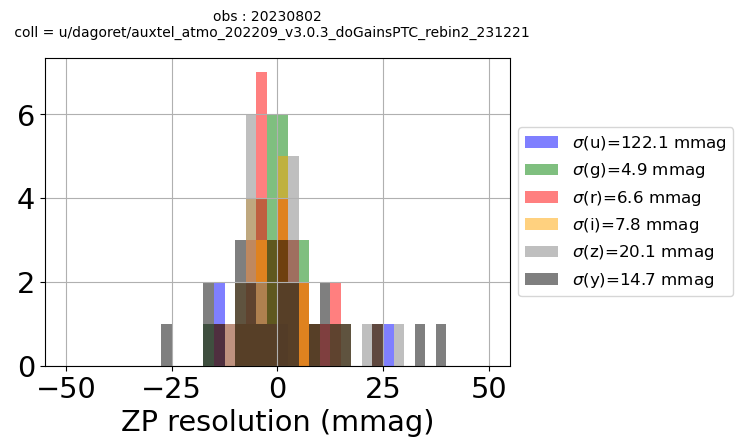

In [168]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
for index,f in enumerate(filter_tagnames):
    X = (zp[f] - np.median(zp[f]))*1000.
    std = np.std(X)
    label = f"$\sigma$({f})={std:.1f} mmag"
    axs.hist(X,bins=40,range=(-50,50),color=filter_color[index],alpha=0.5,label=label)
axs.grid()
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_xlabel("ZP resolution (mmag)")
suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
plt.suptitle(suptitle,fontsize=10,y=1.0)

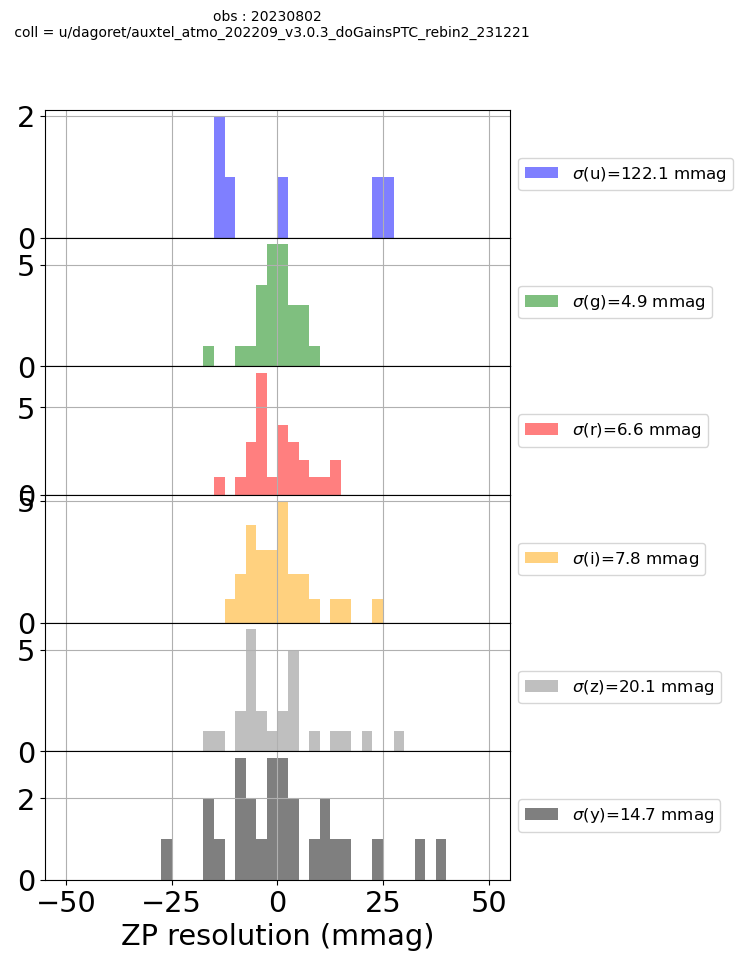

In [169]:
fig, axs = plt.subplots(6,1,figsize=(6,10),sharex = True)
for index,f in enumerate(filter_tagnames):
    X = (zp[f] - np.median(zp[f]))*1000.
    std = np.std(X)
    label = f"$\sigma$({f})={std:.1f} mmag"
    axs[index].hist(X,bins=40,range=(-50,50),color=filter_color[index],alpha=0.5,label=label)
    axs[index].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[index].grid()
axs[5].set_xlabel("ZP resolution (mmag)")
suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
plt.suptitle(suptitle,fontsize=10)
plt.subplots_adjust(hspace=.0)
#plt.tight_layout()

In [170]:
for index,f in enumerate(filter_tagnames):
    print(f,zp[f], all_total_II0_mjd[f] ) 

u [-3.47726415 -3.42790991 -3.55477395 -3.44259151 -3.46743938 -3.59208807
 -3.55725115 -3.41949479 -3.64606377 -3.59475721 -3.7640386  -3.59344992
 -3.77845357 -3.76063831 -3.80063743 -3.52044898 -3.63250866 -3.48697754
 -3.37466174 -3.58079601 -3.6484832 ] [60159.03168869 60159.03348223 60159.03398006 60159.07022804
 60159.07604881 60159.08253712 60159.09714212 60159.10535656
 60159.10736703 60159.1176642  60159.12397067 60159.1244684
 60159.12640091 60159.13234243 60159.13741314 60159.13940771
 60159.15718165 60159.16233    60159.16428605 60159.18308678
 60159.18557302]
g [-2.21773645 -2.22046965 -2.22460265 -2.22437241 -2.22867077 -2.22758004
 -2.23412255 -2.22513891 -2.22236008 -2.21898566 -2.22888145 -2.22374269
 -2.22205435 -2.22636736 -2.22659461 -2.22546452 -2.22289423 -2.22634959
 -2.23040014 -2.22556526 -2.22964205 -2.23092126 -2.22438351 -2.21931598
 -2.22774865 -2.24132943] [60158.96827838 60158.97000576 60159.03168869 60159.03348223
 60159.03398006 60159.04619593 60159.05

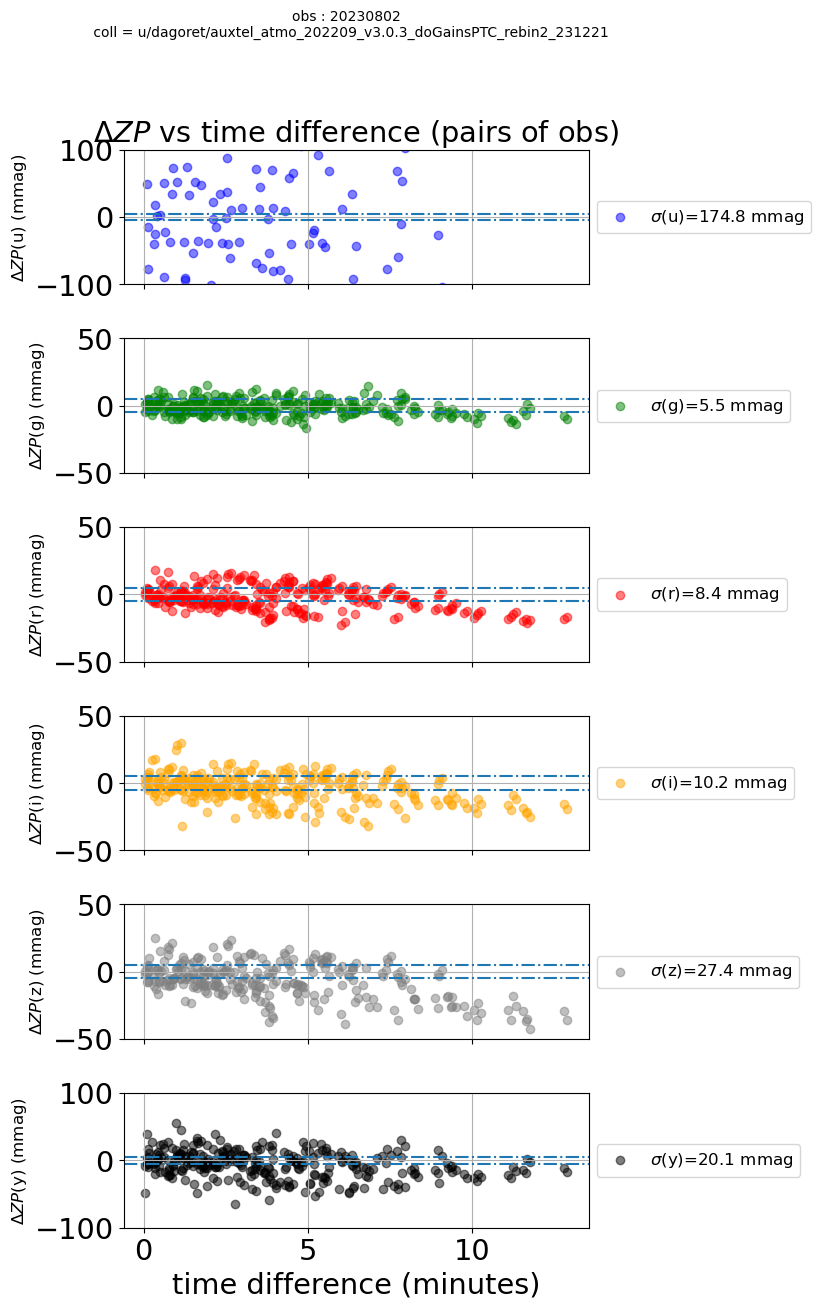

In [171]:
fig, axs = plt.subplots(6,1,figsize=(6,14),sharex = True)

# loop on filters
for index,f in enumerate(filter_tagnames):
    NZP = len(zp[f])
    allX = []  # delta T in minutes
    allY = []  # delta ZP in mmag
    for ix1 in range(0,NZP-1):
        for ix2 in range(ix1+1,NZP-1):
            dt = (all_total_II0_mjd[f][ix2] - all_total_II0_mjd[f][ix1])*60.0 # minutes
            dzp =  (zp[f][ix2] - zp[f][ix1])*1000 # mmag
            allX.append(dt)
            allY.append(dzp)
    allY = np.array(allY)
    allX = np.array(allX)
    std = np.std(allY)
    label = f"$\sigma$({f})={std:.1f} mmag"
    
    axs[index].scatter(allX,allY,color=filter_color[index],alpha=0.5,label=label)
    axs[index].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[index].grid()

    if f == "u"  or f == "y" :
         axs[index].set_ylim(-100,100)
    else:
         axs[index].set_ylim(-50,50)

    axs[index].set_ylabel("$\Delta ZP$" + f"({f}) (mmag)",fontsize=12)
    if f == "u" :
         axs[index].set_title("$\Delta ZP$ vs time difference (pairs of obs)")
    if f == "y" :
         axs[index].set_xlabel("time difference (minutes)")

    axs[index].axhline(-5.0,linestyle = "-.")
    axs[index].axhline(+5.0,linestyle = "-.")


suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
plt.suptitle(suptitle,fontsize=10)
plt.subplots_adjust(hspace=.4)
#plt.tight_layout()

## Information from atmospheric fits

In [172]:
columns_spectrum = ["id"]

for h in headers[0]:
    if "COMMENT" in h or "EXTNAME" in h: continue
    if "LBDAS_T" in h or "PSF_P_T" in h or "AMPLIS_T" in h: continue
    if "UNIT" in h: continue
    if "SIMPLE" in h: continue
    columns_spectrum.append(h)
 
columns_spectrogram_bestfit = []
for key in params_spectrogram[0].labels:
    columns_spectrogram_bestfit.append(key)
    columns_spectrogram_bestfit.append(key+"_err")

columns_spectrum_bestfit = []
for key in params_spectrum[0].labels:
    columns_spectrum_bestfit.append(key)
    columns_spectrum_bestfit.append(key+"_err")

In [173]:
min_index = 0
max_index = np.inf

df1 = pd.DataFrame(columns=columns_spectrum)

for k, header in enumerate(headers):
    # if k > 40: break
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for h in header:
        if h in columns_spectrum:
            row[h] = header[h]
    df1.loc[len(df1)] = row
            
df2 = pd.DataFrame(columns=columns_spectrogram_bestfit)

for k, p in enumerate(params_spectrogram):
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for i, key in enumerate(p.labels):
        row[key] = p.values[i]
        row[key+"_err"] = p.err[i]
    df2.loc[len(df2)] = row
            
df3 = pd.DataFrame(columns=columns_spectrum_bestfit)

for k, p in enumerate(params_spectrum):
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for i, key in enumerate(p.labels):
        row[key] = p.values[i]
        row[key+"_err"] = p.err[i]
    df3.loc[len(df3)] = row
            

In [174]:
df = pd.merge(df1, df2, left_index=True, right_index=True)
df = pd.merge(df, df3, left_index=True, right_index=True)
df.set_index('DATE-OBS', inplace=True)
#df.index = pd.to_datetime(df.index, format="ISO8601") #['DATE-OBS'])
df.index = pd.to_datetime(df.index) #['DATE-OBS'])
df.sort_index(inplace=True)

In [175]:
# convert pandas to numpy rec array
rec = df.to_records()

In [176]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

38
36
35
35
35
35


In [177]:
stars = np.unique(rec["TARGET"])
stars

array(['HD146233', 'HD14943', 'HD185975'], dtype=object)

In [178]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

In [179]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.7,1.3]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,10.]
ATMMINMAX["VAOD_y"] = [0.,0.2]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.7,1.3]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,10.]
ATMMINMAX["VAOD_x"] = [0.,0.2]
ATMMINMAX["A2_x"] = [0.7,1.3]

## Open Fitted param files

In [180]:
#f_atmparamfitted  = h5py.File(fitted_paramfile, 'a') 
#g = f_atmparamfitted.create_group(str(DATEOBS))

FLAG_KEYS_FOUND = False
FLAG_FITTEDPARAM_FOUND = False
datetag_str = str(DATEOBS)

try:
    with h5py.File(fitted_paramfile, mode='r') as f_atmparamfitted:
        all_keys = list(f_atmparamfitted.keys())
        FLAG_KEYS_FOUND = True
        print("all keys found ",all_keys)

        # read all keys already registered    
        #df_dict = {}
        #for k in all_keys:
        #    if k != datetag_str:
        #        df_dict[k] = pd.read_hdf(f_atmparamfitted, key=k)

        
        f_atmparamfitted.close()
except (KeyError, TypeError, FileNotFoundError):
    FLAG_KEYS_FOUND = False
    f_atmparamfitted.close()



all keys found  ['20230802']


### Overwrite the average fitted parameters

In [181]:
f_atmparamfitted = h5py.File(fitted_paramfile, mode='w')
group_dateobs = f_atmparamfitted.create_group(datetag_str)

In [182]:
group_dateobs

<HDF5 group "/20230802" (0 members)>

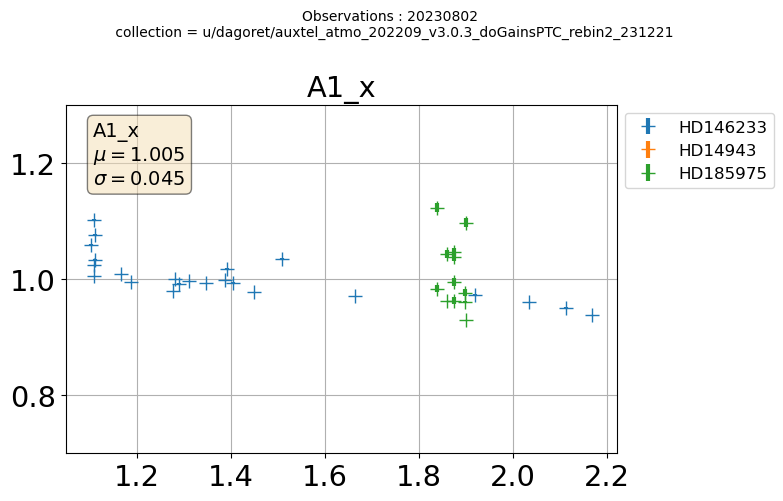

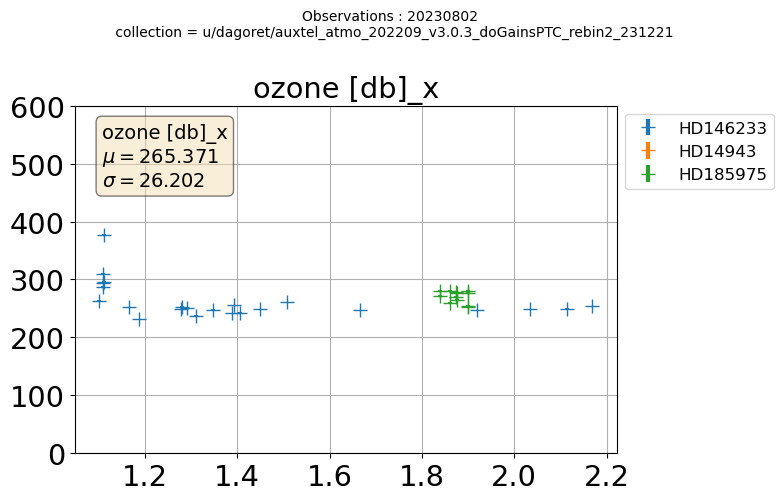

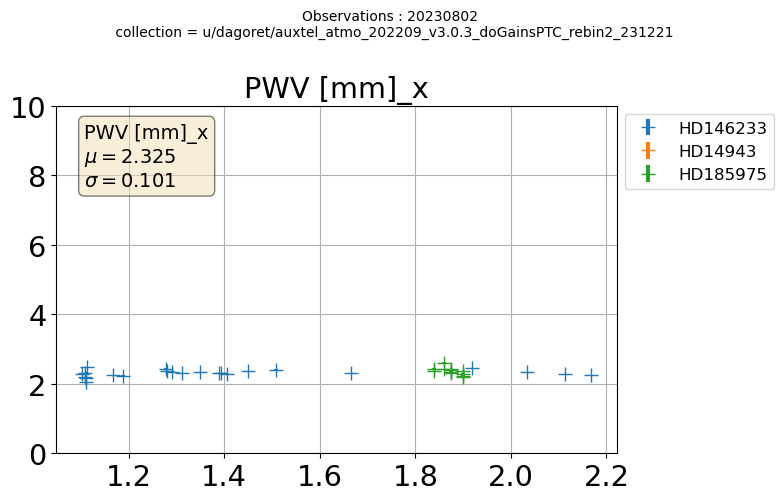

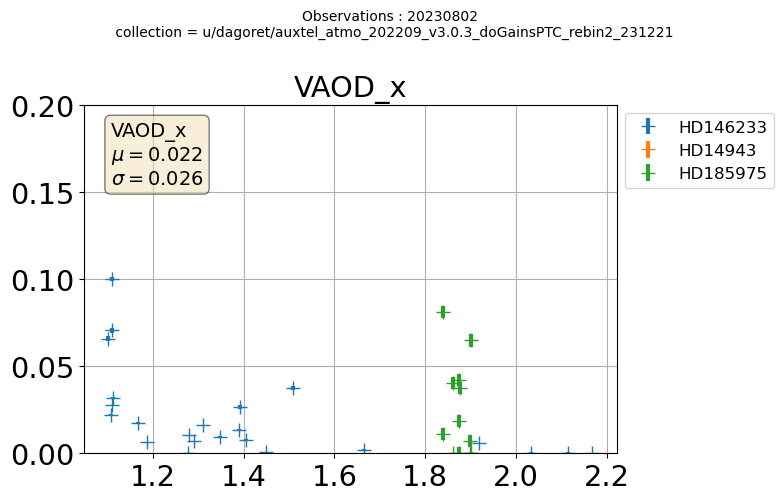

In [183]:
#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x", "gamma_0_1", "gamma_0_2", "alpha_0_1", "alpha_0_2", "y_c_0_1", "y_c_0_2" ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    # save the average on the attribute
    group_dateobs.attrs[col] = mu

    for star in stars:
        index = filtered & (rec["TARGET"] == star) & (rec["FILTER"]=="empty")
        if col_err in df.columns:
            plt.errorbar(rec["AIRMASS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=10,lw=3 ,label=star)
        else:
            plt.plot(rec["AIRMASS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3 )
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    #plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()
f_atmparamfitted.close()

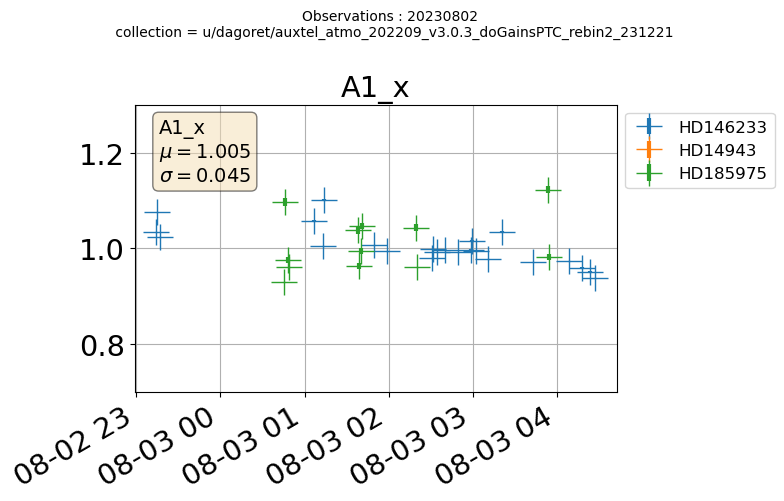

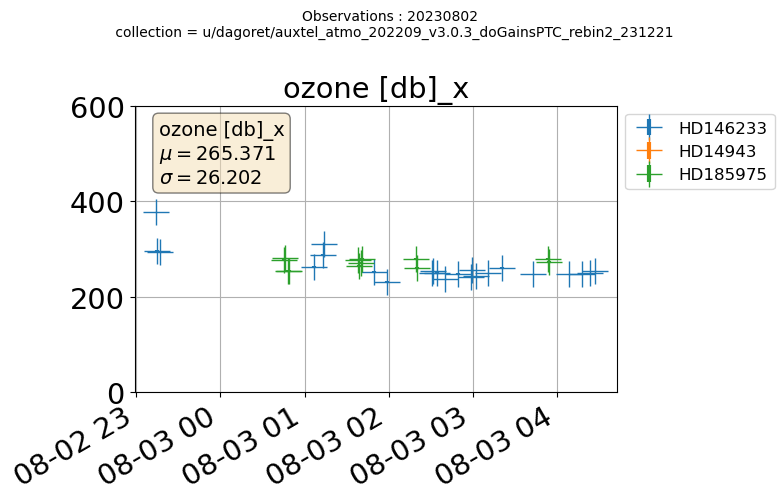

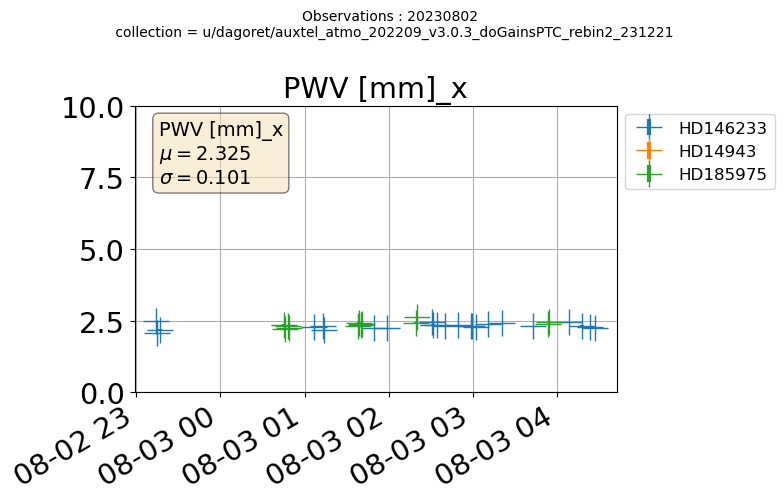

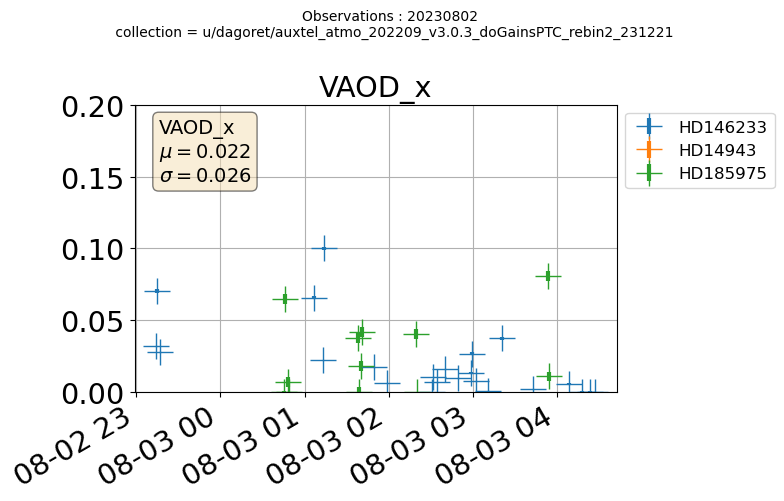

In [184]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(8,5))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()